In [5]:
!pip install torch

You should consider upgrading via the '/Users/nikasakandelidze/deeplearning/deeplearning/bin/python -m pip install --upgrade pip' command.


In [6]:
import torch

In [7]:
names = open('names.txt').read().split("\n")

In [8]:
print(len(names))

32033


In [9]:
print(min([len(x) for x in names]))
print((max([len(x) for x in names])))

2
15


In [25]:
# bi-gram model
stats = torch.ones([28, 28], dtype=torch.int32)

def get_indexes(prev, nxt):
    zero_based_index =  lambda i : ord(i) - 97
    if prev == '<START>' and nxt == '<END>':
        return 0,27
    elif prev == '<START>':
        return 0, zero_based_index(nxt)+1
    elif nxt == '<END>':
        return zero_based_index(prev)+1, 27
    else:
        return zero_based_index(prev)+1, zero_based_index(nxt)+1
    
def get_chars(prevIdx, nxtIdx):
    if prevIdx == 0:
        prev = '<START>'
    else:
        prev = chr(prevIdx+96)
    if nxtIdx == 27:
        nxt = '<END>'
    else:
        nxt = chr(nxtIdx+96)
    return prev,nxt

        

curr_max = [None, float('-inf')]
curr_min = [None, float('inf')]
for name in names:
    word = ['<START>'] + list(name) + ['<END>']
    for prev, nxt in zip(word, word[1:]):
        i,j = get_indexes(prev, nxt)
        stats[i][j] += 1
        if stats[i][j]>curr_max[1]:
            curr_max[0] = get_chars(i,j)
            curr_max[1] = stats[i][j]
        
        if stats[i][j]<curr_min[1]:
            curr_min[0] = get_chars(i, j)
            curr_min[1] = stats[i][j]

print(curr_max, curr_min)

# max_idx = stats.argmax()
# y_max, x_max = max_idx // 28, max_idx % 28

# print(chr(y_max+97), chr(x_max+97), stats[y_max][x_max])


# stats[stats == 0] = stats[y_max][x_max] + 10 # custom solution to not interfere with min calc
# min_idx = stats.argmin()
# y_min, x_min = min_idx // 28, min_idx % 28

# print(chr(y_min+97), chr(x_min+97), stats[y_min][x_min])

[('n', '<END>'), tensor(6764, dtype=torch.int32)] [('p', 'f'), tensor(2, dtype=torch.int32)]


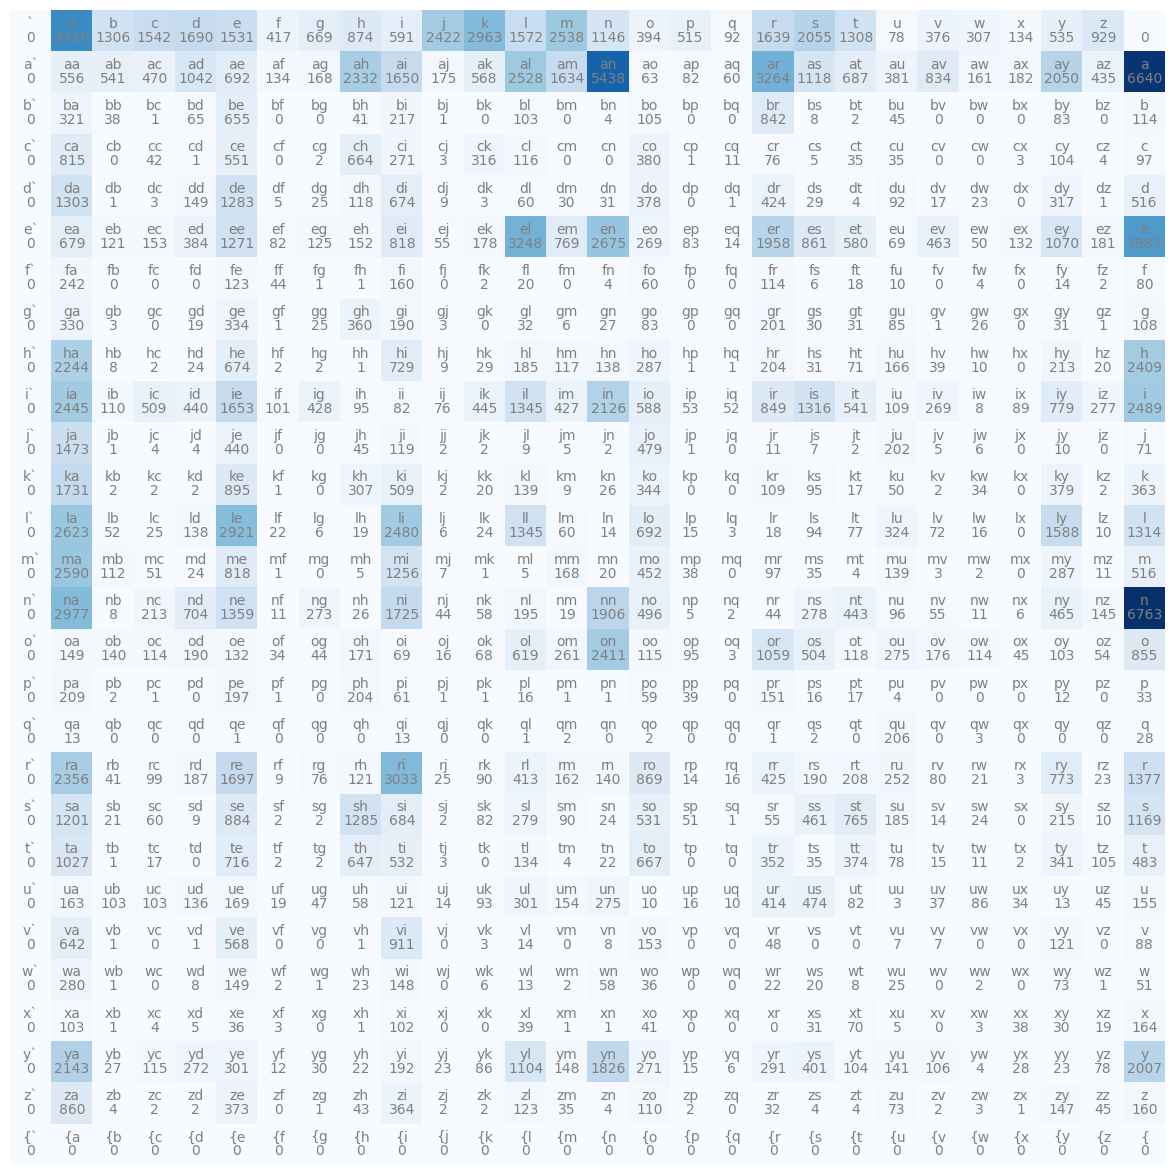

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(15,15))
plt.imshow(stats, cmap='Blues')
for i in range(28):
    for j in range(28):
        if i == 0:
            prev = '' 
        else:
            prev = chr(i+96)
        if j == 27:
            nxt = ''
        else:
            nxt = chr(j+96)
        chstr =   prev + nxt
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, stats[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [12]:

g = torch.Generator().manual_seed(214748364)

def generate_bigram_name(curr_idx=0):
    def helper(curr_idx):
        probabilities = stats[curr_idx].float()
        # Here is a probability distribution for starting characters
        probabilities /= probabilities.sum()
        idx = torch.multinomial(probabilities, num_samples=1, replacement=True, generator=g).item()
        # Not fully understand the base case
        if idx == 0 or idx == 27:
            return ''
        return chr(idx+96) + helper(idx)
    return helper(curr_idx)

for i in range(10):
    print(generate_bigram_name())

amannne
jay
n
een
cabrera
ja
mase
torrety
va
ka


In [24]:
# probabilities for specific bigrams
log_likelihood = 0
count = 0
for name in ['andrejq']:
    word = ['<START>'] + list(name) + ['<END>']
    for prev, nxt in zip(word, word[1:]):
        i, j = get_indexes(prev, nxt)
        arr = stats[i].float()
        arr /= arr.sum()
        prob = arr[j]
        log_prob = torch.log(prob)
        # we sum this up since otherwise we should have used probabilities directly and in that case we would have
        # used product of probabilities. Since we are using logs log(a*b) = log(a) + log(b)
        log_likelihood += log_prob 
        count += 1
        print(f'{prev}{nxt} probability: {prob}; log probability: {log_prob:.4f}')
print(log_likelihood)
nll = -log_likelihood/count
print(nll) # avg log likelihood
        

<START>a probability: 0.13767053186893463; log probability: -1.9829
an probability: 0.16048398613929749; log probability: -1.8296
nd probability: 0.03841327130794525; log probability: -3.2594
dr probability: 0.07714701443910599; log probability: -2.5620
re probability: 0.13362205028533936; log probability: -2.0127
ej probability: 0.0026930421590805054; log probability: -5.9171
jq probability: 0.0; log probability: -inf
q<END> probability: 0.10294117778539658; log probability: -2.2736
tensor(-inf)
tensor(inf)
